# Task 9 – Model-based swing-up planning

This notebook estimates the pendulum parameters (\(\alpha_1,\alpha_2\)) from recorded demonstrations and builds a CasADi-based swing-up planner that mirrors Section 6 of Atkeson & Schaal (1997).

In [1]:
import os
import sys
from pathlib import Path

current = Path.cwd()
if (current / 'notebooks').exists():
    PROJECT_ROOT = current
else:
    PROJECT_ROOT = current.parent

os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project root:', PROJECT_ROOT)

Project root: /home/acepeax/Desktop/Studies/MVA/Robotics/Project


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca


from scripts.task_7_env import Task7PendulumEnv, Y_MAX

pybullet build time: Dec  4 2025 20:11:42


In [3]:
def wrap_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

USE_DOWN_ZERO = False

In [5]:
DATA_DIR = Path('data')
MANUAL_DATA_DIR = DATA_DIR / 'task8_manual'
DEFAULT_RECORDING = DATA_DIR / 'swing_up_demo.npz'
SIM_SUBSTEPS = 6  # must match the recording
BASE_DT = 1.0 / 240.0
STEP_DT = BASE_DT * SIM_SUBSTEPS
GRAVITY = 9.81

print('Using step dt =', STEP_DT)

Using step dt = 0.025


In [6]:
def plan_swing_up(
    alpha1,
    alpha2,
    horizon_steps=360,
    step_dt=STEP_DT,
    y_limit=0.6,
    y_vel_limit=6.0,
    start_state=None,
    weights=None,
    initial_guess=None,
):
    if start_state is None:
        start_state = np.array([np.pi - 0.05, 0.0, 0.0, 0.0], dtype=float)
    if weights is None:
        weights = {
            'theta': 3.0,
            'theta_dot': 0.5,
            'y': 1.5,
            'y_dot': 0.2,
            'u': 0.001,
            'terminal_theta': 20.0,
            'terminal_theta_dot': 2.0,
        }
    opti = ca.Opti()
    X = opti.variable(4, horizon_steps + 1)  # theta, theta_dot, y, y_dot
    U = opti.variable(1, horizon_steps)      # commanded acceleration in y
    opti.subject_to(X[:, 0] == start_state.reshape(-1, 1))
    cost = 0
    for k in range(horizon_steps):
        theta = X[0, k]
        theta_dot = X[1, k]
        y = X[2, k]
        y_dot = X[3, k]
        u_y = U[0, k]
        theta_dot_next = (1.0 - alpha1) * theta_dot + alpha2 * (
            ca.sin(theta) + (u_y / GRAVITY) * ca.cos(theta)
        )
        theta_next = theta + step_dt * theta_dot_next
        y_dot_next = y_dot + step_dt * u_y
        y_next = y + step_dt * y_dot_next
        state_next = ca.vertcat(theta_next, theta_dot_next, y_next, y_dot_next)
        opti.subject_to(X[:, k + 1] == state_next)
        opti.subject_to(opti.bounded(-y_limit, y_next, y_limit))
        opti.subject_to(opti.bounded(-y_vel_limit, y_dot_next, y_vel_limit))
        cost += (
            weights['theta'] * theta_next**2
            + weights['theta_dot'] * theta_dot_next**2
            + weights['y'] * y_next**2
            + weights['y_dot'] * y_dot_next**2
            + weights['u'] * (u_y**2)
        )
    theta_T = X[0, -1]
    theta_dot_T = X[1, -1]
    cost += weights['terminal_theta'] * theta_T**2 + weights['terminal_theta_dot'] * theta_dot_T**2
    opti.minimize(cost)
    if initial_guess is not None:
        X_guess, U_guess = initial_guess
        if X_guess.shape == (4, horizon_steps + 1):
            opti.set_initial(X, X_guess)
        if U_guess.shape == (1, horizon_steps):
            opti.set_initial(U, U_guess)
    opti.solver('ipopt', {'ipopt.print_level': 0, 'print_time': False, 'ipopt.max_iter': 4000, 'ipopt.acceptable_tol': 1e-3, 'ipopt.acceptable_obj_change_tol': 1e-4, 'ipopt.mu_strategy': 'adaptive', 'ipopt.hessian_approximation': 'limited-memory', 'ipopt.linear_solver': 'mumps'})
    sol = opti.solve()
    result = {
        'theta': np.array(sol.value(X[0, :])).flatten(),
        'theta_dot': np.array(sol.value(X[1, :])).flatten(),
        'y': np.array(sol.value(X[2, :])).flatten(),
        'y_dot': np.array(sol.value(X[3, :])).flatten(),
        'u': np.array(sol.value(U[0, :])).flatten(),
        'step_dt': step_dt,
    }
    return result


In [ ]:
def plan_swing_up_from_obs(obs):
    horizon = 80
    start_state = obs
    alpha1 = 0.0046048197513445435
    alpha2 = 0.7330850339644795
    plan = plan_swing_up(
        alpha1,
        alpha2,
        horizon_steps=horizon,
        y_limit=0.6,
        y_vel_limit=2.0,
        start_state=start_state,
        weights={
            'theta': 5.0,
            'theta_dot': 0.5,
            'y': 1.5*3,
            'y_dot': 0.9,
            'u': 0.0135,
            'terminal_theta': 30.0,
            'terminal_theta_dot': 4.0,
        },
    )
    return plan

In [ ]:
K_lqr = np.array([[
    6.78476634e+00,  5.28904201e-01, -1.46821116e+03,  5.47085021e+03,
    1.22385258e+03,  5.33145726e+00, -2.37202244e+01, -4.88098112e+00,
    1.47333821e+03, -5.47849355e+03, -1.22381746e+03,  9.59106566e-01,
    2.93051478e-01, -2.42449741e-01
]])
ACTION_VALUES = np.array([-Y_MAX, 0.0, Y_MAX], dtype=np.float32)
class Task7LQRPolicy:
    def __init__(self, K, use_continuous=False):
        self.K = K
        self.use_continuous = use_continuous

    def predict(self, obs, deterministic=True):
        u = float(-(self.K @ obs.reshape(-1, 1)))
        if self.use_continuous:
            return np.array([[np.clip(u, -1.0, 1.0)]], dtype=np.float32), None
        clipped = np.clip(u, ACTION_VALUES.min(), ACTION_VALUES.max())
        idx = int(np.argmin(np.abs(ACTION_VALUES - clipped))) - 1
        return idx, None

lqr_policy = Task7LQRPolicy(K_lqr, use_continuous=False)

argv[0]=--minLoggingLevel=3
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = --minLoggingLevel=3
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
GL_VERSION=4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaroun

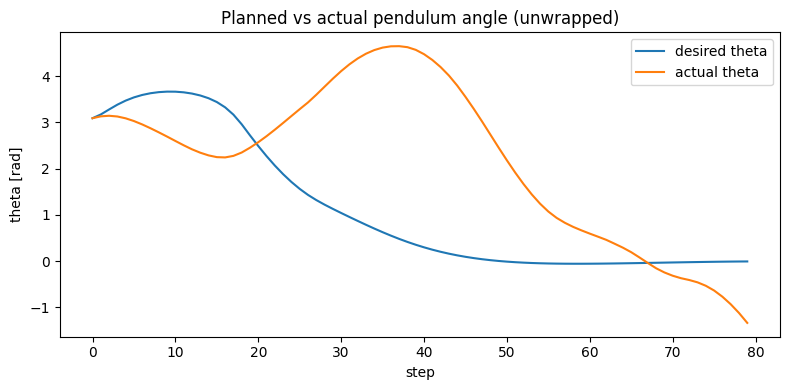

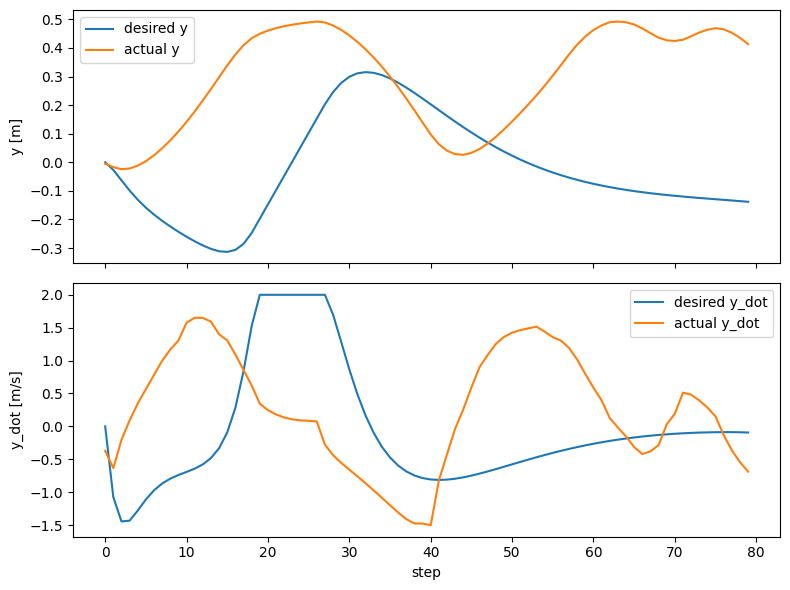

In [ ]:
def rollout_plan_in_env(env, gui=False):
    actions = []
    rewards = []
    desired_thetas = []
    actual_thetas = []
    desired_y = []
    actual_y = []
    desired_y_dot = []
    actual_y_dot = []
    obs, _ = env.reset()
    plan = plan_swing_up_from_obs(obs)
    for k, u in enumerate(plan['u']):
        target = np.clip(u / (abs(u) + 1e-8), -1.0, 1.0)
        action = np.array([[target]], dtype=np.float32)
        obs, reward, terminated, _, info = env.step(action)
        des_theta = plan['theta'][min(k, len(plan['theta']) - 1)]
        des_y_val = plan['y'][min(k, len(plan['y']) - 1)]
        des_y_dot_val = plan['y_dot'][min(k, len(plan['y_dot']) - 1)]
        act_theta = obs[0]
        act_y = obs[9]
        act_y_dot = obs[12]
        y_target = env.current_y_target if hasattr(env, 'current_y_target') else np.nan
        actions.append(action)
        rewards.append(reward)
        desired_thetas.append(des_theta)
        actual_thetas.append(act_theta)
        desired_y.append(des_y_val)
        actual_y.append(act_y)
        desired_y_dot.append(des_y_dot_val)
        actual_y_dot.append(act_y_dot)
        if terminated:
            break
    if not terminated:
        # WRITE HERE
        pass
    des_t = np.array(desired_thetas)
    act_t = np.array(actual_thetas)
    des_unwrap = np.unwrap(des_t)
    act_unwrap = np.unwrap(act_t)
    offset = des_unwrap[0] - act_unwrap[0]
    act_unwrap += offset
    return (
        np.array(actions),
        np.array(rewards),
        des_unwrap,
        act_unwrap,
        np.array(desired_y),
        np.array(actual_y),
        np.array(desired_y_dot),
        np.array(actual_y_dot),
    )

# Example (runs headless)
env = Task7PendulumEnv(gui=True, should_balance=False, sim_substeps=SIM_SUBSTEPS, continuous_actions=True)
rollout_actions, rollout_rewards, des_t, act_t, des_y, act_y, des_y_dot, act_y_dot = rollout_plan_in_env(env, gui=True)
env.close()
print('Rollout length:', len(rollout_actions))

